Old Guestbook IP Extraction
===

This script processes the json guestbook in the old (2016) dataset to a CSV file containing the IP metadata.


In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [12]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support')

In [13]:
import sys
caringbridge_core_path = "/home/srivbane/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [14]:
import cbcore.data.paths as paths
import cbcore.data.dates as dates

In [15]:
raw_data_dir = paths.raw_data_2016_filepath

In [16]:
guestbook_filepath = os.path.join(raw_data_dir, "guestbook_scrubbed.json")

In [17]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data"
os.makedirs(working_dir, exist_ok=True)
assert os.path.exists(working_dir)

### Load and convert journal file

In [18]:
output_filepath = os.path.join(working_dir, "gb_ip_raw.csv")

In [32]:
bad_ips = []
with open(output_filepath, 'w') as outfile:
    with open(guestbook_filepath, encoding='utf-8') as infile:
        for line in tqdm(infile, total=82980359):
            gb = json.loads(line)
            
            if "ip" not in gb:
                continue
            ip = gb['ip']
            if not re.match(r"[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+$", ip):
                bad_ips.append(ip)
                continue
            
            created_at = int(gb["createdAt"]["$date"])
            updated_at = int(gb["updatedAt"]["$date"]) if "updatedAt" in gb else ""

            outfile.write(f"{int(gb['userId'])},{ip},{int(gb['siteId'])},{created_at},{updated_at}\n")

100%|██████████| 82980359/82980359 [24:00<00:00, 57600.89it/s]


In [33]:
len(bad_ips)

95863

In [34]:
Counter(bad_ips).most_common()[:10]

[('unknown', 18309),
 ('96.39.172.11, 12', 548),
 ('10.1.0.157, 127.', 219),
 ('192.1.8.126, 192', 213),
 ('10.49.50.69, 10', 195),
 ('127.0.0.1, 127.0', 168),
 ('10.9.100.62, 12', 164),
 ('10.83.252.26, 10', 155),
 ('10.100.250.66, 2', 155),
 ('10.49.50.69, 10.', 154)]

In [35]:
!wc -l {output_filepath}

76810342 /home/srivbane/shared/caringbridge/data/projects/sna-social-support/geo_data/gb_ip_raw.csv


### Add geo information to data

This is now in a separate PBS script for easier execution as an independent, long-running job.

In [24]:
raw_ip_filepath = os.path.join(working_dir, "gb_ip_raw.csv")
geo_info_added_filepath = os.path.join(working_dir, "gb_geo_data.csv")

In [25]:
# read the geoip2 database
import geoip2
import geoip2.database
city_database_filepath = "/home/srivbane/shared/caringbridge/data/derived/geolite2/GeoLite2-City_20190813/GeoLite2-City.mmdb"
reader = geoip2.database.Reader(city_database_filepath)

In [ ]:
with open(raw_ip_filepath, 'r') as infile:
    with open(geo_info_added_filepath, 'w') as outfile:
        for line in tqdm(infile, total=76810342):
            tokens = line.strip().split(",")
            if len(tokens) != 5:
                raise ValueError(f"Too many values to unpack: {line}")
            user_id, ip, site_id, created_at, updated_at = tokens
            try:
                g = reader.city(ip)
            except geoip2.errors.AddressNotFoundError:
                outfile.write(f"{user_id},{site_id},{created_at},NOT_FOUND,,,,,,\n")
                continue
            country = g.country.iso_code
            subdiv_count = len(g.subdivisions)
            state = g.subdivisions.most_specific.iso_code
            city = g.city.name
            lat = g.location.latitude
            long = g.location.longitude
            acc_radius = g.location.accuracy_radius
            
            outfile.write(f"{user_id},{site_id},{created_at},{country},{subdiv_count},{state},{city},{lat},{long},{acc_radius}\n")

### Read csv file

In [41]:
header = ['user_id','site_id','created_at','country','subdiv_count','state','city','lat','long','acc_radius']
df = pd.read_csv(geo_info_added_filepath, header=None, names=header)
len(df)

71605

In [ ]:
df.head()

In [43]:
Counter(df.country).most_common()[:15]

[('US', 67658),
 ('CA', 1672),
 ('NOT_FOUND', 1184),
 ('GB', 452),
 ('AU', 209),
 ('SG', 58),
 ('FR', 49),
 ('CN', 41),
 ('DE', 38),
 ('NZ', 37),
 ('MY', 20),
 ('JP', 18),
 ('LB', 15),
 ('SA', 13),
 ('NL', 12)]

In [44]:
Counter(df.state).most_common()[:15]

[('None', 19882),
 ('NY', 4807),
 ('MS', 3562),
 ('WA', 2687),
 ('MN', 2666),
 ('TX', 2569),
 ('PA', 2404),
 ('IL', 2282),
 ('OH', 2215),
 ('IN', 1912),
 ('FL', 1837),
 ('GA', 1742),
 ('NC', 1540),
 ('MI', 1511),
 ('CA', 1407)]

In [52]:
Counter(df.city).most_common()[:15]

[('None', 20145),
 ('Brooklyn', 1663),
 ('Jackson', 1575),
 ('Holbrook', 1449),
 ('Seattle', 1316),
 (nan, 1184),
 ('Chicago', 758),
 ('Minneapolis', 668),
 ('Michigan City', 639),
 ('Saint Paul', 633),
 ('Ellijay', 513),
 ('Memphis', 507),
 ('Dallas', 504),
 ('Columbus', 497),
 ('Rockford', 416)]

In [46]:
Counter(df.acc_radius).most_common()[:15]

[('1000', 22769),
 ('10', 14092),
 ('5', 12985),
 ('20', 7613),
 ('100', 4933),
 ('50', 4169),
 ('1', 1882),
 ('200', 1329),
 (nan, 1184),
 ('500', 646),
 ('None', 3)]

In [48]:
Counter(df.subdiv_count).most_common()[:3]

[(1.0, 50214), (0.0, 19882), (2.0, 325)]

In [51]:
# multiple subdivisions is a non-US thing
Counter(df[df.subdiv_count == 2].country).most_common()

[('GB', 266), ('FR', 48), ('IT', 4), ('PH', 4), ('IE', 2), ('ES', 1)]

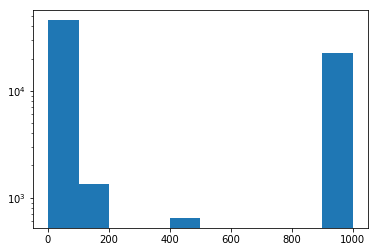

In [57]:
plt.hist([int(ar) for ar in df.acc_radius if ar is not None and ar != 'None' and not pd.isnull(ar)], log=True)
plt.title("Accuracy radius for the classified points")
plt.show()

### Visualization by US state and location

In [58]:
us_df = df[(df.subdiv_count == 1)&(df.country=='US')]
len(us_df), len(us_df) / len(df)

(48437, 0.6764471754765728)

In [61]:
us_df.head()

,user_id,site_id,created_at,country,subdiv_count,state,city,lat,long,acc_radius
0,9093750,190873,1371419599000,US,1.0,WI,Menomonee Falls,43.1604,-88.1173,10
1,3582245,7319,1371406238000,US,1.0,ND,Oakes,46.1095,-98.2257,50
2,11105735,227945,1371420142000,US,1.0,TX,Katy,29.7388,-95.8309,5
3,24244023,76167,1371409559000,US,1.0,NY,Derby,42.6974,-78.9834,20
7,2738416,48799,1371414879000,US,1.0,WA,Seattle,47.54,-122.3032,1000


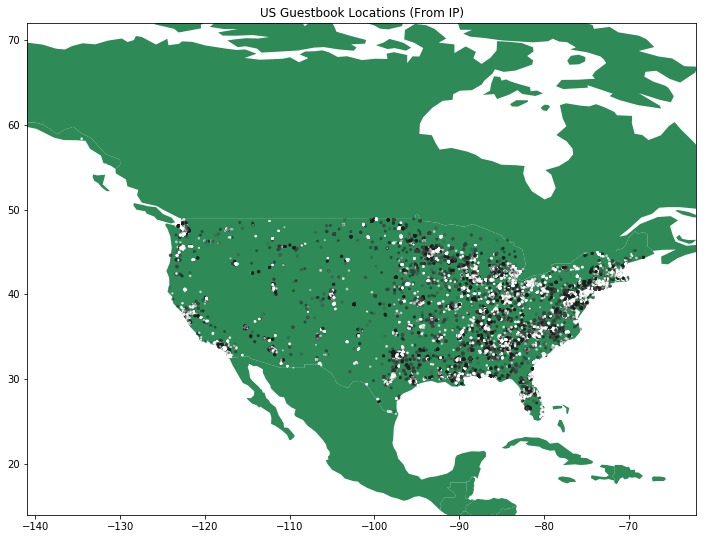

In [99]:
import geopandas as gpd
import geopandas.datasets
import shapely
#from quilt.data.ResidentMario import geoplot_data

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = gpd.read_file(geoplot_data.contiguous_usa())
world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1,1, figsize=(12,12))

ax = world.plot(ax=ax, color="seagreen")

marker_size_map = {'1000': 9,
                   '500': 8,
                   '200': 7, 
                   '100': 6, 
                   '50': 5, 
                   '20': 4,
                   '10': 3, 
                   '5': 2,
                   '1': 1
                  }

marker_color_map = {'1000': plt.cm.Greys(0.7, alpha=0.01),
                   '500': plt.cm.Greys(0.7, alpha=0.05),
                   '200': plt.cm.Greys(0.8, alpha=0.2), 
                   '100': plt.cm.Greys(0.8, alpha=0.3), 
                   '50': plt.cm.Greys(0.9, alpha=0.4), 
                   '20': plt.cm.Greys(0.9, alpha=0.4),
                   '10': plt.cm.Greys(1, alpha=0.5), 
                   '5': plt.cm.Greys(1, alpha=0.5),
                   '1': plt.cm.Greys(1, alpha=0.5)
                  }

geometry = [shapely.geometry.Point(xy) for xy in zip(us_df.long.astype("float"), us_df.lat.astype("float"))]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(us_df, crs=crs, geometry=geometry)
gdf = gdf.to_crs(world.crs)  # just to ensure the coordinate system is the same
markersizes = [marker_size_map[ar] for ar in us_df.acc_radius]
colors = [marker_color_map[ar] for ar in us_df.acc_radius]
ax = gdf.plot(ax=ax, color=colors, markersize=markersizes)

# try to apply different colors to the response categories in order to sanity check the demo_country variable
#ax = gdf[gdf["demo_country"] == "USA"].plot(ax=ax, color='blue', markersize=4)
#ax = gdf[gdf["demo_country"] == "Canada"].plot(ax=ax, color='red', markersize=4)
#ax = gdf[gdf["demo_country"] == "Other"].plot(ax=ax, color='white', markersize=2)

# some hacky estimates of North America coords
ax.set_xlim((-141,-62))
ax.set_ylim((14,72))

_ = ax.set_title("US Guestbook Locations (From IP)")